ted to old model, fix them 
# TeleScent ML Model Training - NATURAL_ML_Data
## Scent Detection using Natural Dataset

This notebook trains a machine learning model to predict scents based on sensor data from the NATURAL_ML_Data.xlsx dataset.

### Workflow:
1. **Import Libraries** - Load all required ML and data processing libraries
2. **Load Dataset** - Read NATURAL_ML_Data.xlsx file
3. **Explore Data** - Understand the dataset structure and statistics
4. **Preprocess Data** - Clean, handle missing values, and prepare features
5. **Train Models** - Build and train classification models
6. **Evaluate Performance** - Assess model accuracy and performance metrics
7. **Save Model** - Export trained model for production use

### Dataset:
- **Source**: NATURAL_ML_Data.xlsx
- **Features**: Sensor readings (temperature, humidity, pressure, gas, VOC, NOx, etc.)
- **Target**: Scent labels

### Expected Outputs:
- Trained model saved to `model/scent_pipeline.joblib`
- Label encoder saved to `model/label_encoder.joblib`
- Performance metrics and visualizations

## 1. Import Required Libraries

In [32]:
import os
import json
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import joblib

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [33]:
# Dataset configuration
DATA_FILE = 'NATURAL_ML_Data_with_no_scent.xlsx'  # Modified dataset with no_scent class

# Model output paths
MODEL_DIR = Path('model')
MODEL_DIR.mkdir(exist_ok=True)

PIPELINE_PATH = MODEL_DIR / 'scent_pipeline.joblib'
LABEL_ENCODER_PATH = MODEL_DIR / 'label_encoder.joblib'

# Training parameters
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_ESTIMATORS = 100
MAX_DEPTH = 20

print("✅ Configuration loaded!")
print(f"📁 Data file: {DATA_FILE}")
print(f"💾 Model will be saved to: {PIPELINE_PATH}")
print(f"📌 Using dataset with 'no_scent' baseline class")

✅ Configuration loaded!
📁 Data file: NATURAL_ML_Data_with_no_scent.xlsx
💾 Model will be saved to: model/scent_pipeline.joblib
📌 Using dataset with 'no_scent' baseline class


## 2. Configuration

## 3. Load Dataset from Excel File

In [34]:
# Load the dataset from Excel file
print(f"📖 Loading dataset from {DATA_FILE}...")

try:
    # Load cleaned data (4 scents: cinnamon, gingerbread, orange, vanilla)
    # Note: norange data has been removed and replaced with orange data
    df = pd.read_excel(DATA_FILE)
    print(f"✅ Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
    
    print(f"\n🎯 Classes in dataset:")
    print(df['scent_name'].value_counts())
    
    print(f"\n🔍 Column names:")
    for i, col in enumerate(df.columns, 1):
        print(f"  {i}. {col}")
    
    # Verify we have the expected scents
    expected_scents = ['cinnamon', 'gingerbread', 'orange', 'vanilla']
    actual_scents = df['scent_name'].unique().tolist()
    print(f"\n✅ Scents found: {actual_scents}")
    
    if 'norange' in actual_scents:
        print("⚠️ Warning: 'norange' data still present in dataset!")
    else:
        print("✅ Dataset clean - no 'norange' data found")
        
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    print("\n💡 Note: Make sure 'openpyxl' is installed:")
    print("   pip install openpyxl")


📖 Loading dataset from NATURAL_ML_Data_with_no_scent.xlsx...
✅ Dataset loaded: 7920 rows × 17 columns

🎯 Classes in dataset:
scent_name
no_scent       2000
cinnamon       1480
gingerbread    1480
norange        1480
vanilla        1480
Name: count, dtype: int64

🔍 Column names:
  1. sample_id
  2. trial_number
  3. scent_id
  4. scent_name
  5. phase
  6. time_s
  7. timestamp_ms
  8. temp_C
  9. humidity_pct
  10. pressure_kPa
  11. gas_bme
  12. srawVoc
  13. srawNox
  14. NO2
  15. ethanol
  16. VOC_multichannel
  17. COandH2

✅ Scents found: ['no_scent', 'cinnamon', 'gingerbread', 'norange', 'vanilla']
⚠️ Warning: 'norange' data still present in dataset!


In [35]:
# Display first few rows
print("📋 First 5 rows of the dataset:")
print("=" * 80)
display(df.head())

print("\n📊 Dataset Info:")
print("=" * 80)
print(f"Total rows: {len(df)}")
print(f"Total columns: {len(df.columns)}")
print(f"\nData types:")
print(df.dtypes)

print("\n📈 Basic Statistics:")
print("=" * 80)
display(df.describe())

📋 First 5 rows of the dataset:


,sample_id,trial_number,scent_id,scent_name,phase,time_s,timestamp_ms,temp_C,humidity_pct,pressure_kPa,gas_bme,srawVoc,srawNox,NO2,ethanol,VOC_multichannel,COandH2
0,61,1,13,no_scent,baseline,0.000,0,23.31,41.70,101.47,122.62,31317,15073,222,242,286,870
1,61,1,13,no_scent,baseline,1.215,1215,23.31,41.69,101.47,123.43,31241,15081,222,241,287,869
2,61,1,13,no_scent,baseline,2.430,2430,23.31,41.71,101.47,122.00,31247,15081,221,242,287,869
3,61,1,13,no_scent,baseline,3.645,3645,23.31,41.69,101.47,122.62,31248,15082,222,241,286,870
4,61,1,13,no_scent,baseline,4.860,4860,23.31,41.70,101.47,122.71,31273,15072,221,241,287,870



📊 Dataset Info:
Total rows: 7920
Total columns: 17

Data types:
sample_id             int64
trial_number          int64
scent_id              int64
scent_name           object
phase                object
time_s              float64
timestamp_ms          int64
temp_C              float64
humidity_pct        float64
pressure_kPa        float64
gas_bme             float64
srawVoc               int64
srawNox               int64
NO2                   int64
ethanol               int64
VOC_multichannel      int64
COandH2               int64
dtype: object

📈 Basic Statistics:


,sample_id,trial_number,scent_id,time_s,timestamp_ms,temp_C,humidity_pct,pressure_kPa,gas_bme,srawVoc,srawNox,NO2,ethanol,VOC_multichannel,COandH2
count,7920.00000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000
mean,100.51250,10.500000,14.500000,59.534985,59534.985101,23.010739,41.595860,101.655938,108.707938,31197.441162,14998.131061,253.176894,246.498106,293.805051,876.671338
std,23.10178,5.766645,1.118105,34.723705,34723.704948,0.384704,1.333882,0.168030,11.257319,215.368598,140.555157,64.441336,47.193505,54.794035,16.518792
min,61.00000,1.000000,13.000000,0.000000,0.000000,22.330000,39.540000,101.460000,47.040000,29967.000000,14848.000000,152.000000,184.000000,217.000000,849.000000
25%,80.75000,5.750000,13.750000,29.160000,29160.000000,22.710000,40.540000,101.500000,105.150000,31076.000000,14909.000000,203.000000,220.000000,256.000000,864.000000
50%,100.50000,10.500000,14.500000,59.535000,59535.000000,22.990000,41.270000,101.620000,112.040000,31159.000000,14962.000000,241.000000,236.000000,279.000000,878.000000
75%,120.25000,15.250000,15.250000,89.910000,89910.000000,23.300000,42.260000,101.780000,116.000000,31387.000000,15024.000000,298.000000,265.000000,321.000000,884.000000
max,140.00000,20.000000,16.000000,119.070000,119070.000000,24.020000,46.710000,101.940000,123.430000,31644.000000,15704.000000,593.000000,532.000000,612.000000,966.000000


In [36]:
# Identify target column and features
target_col = 'scent_name'

# Metadata columns (NOT used for prediction)
metadata_cols = ['sample_id', 'trial_number', 'scent_id', 'scent_name', 'phase', 'time_s']
if 'timestamp_ms' in df.columns:
    metadata_cols.append('timestamp_ms')

# Feature columns - 6 chemical sensors (scent indicators only)
# Removed environmental conditions: temp_C, humidity_pct, pressure_kPa
# Removed gas_bme: capturing session patterns, not smell chemistry
# These are pure VOC/chemical measurements that directly detect smell molecules
feature_cols = [
    'srawVoc', 'srawNox', 'NO2', 
    'ethanol', 'VOC_multichannel', 'COandH2'
]

print(f"\n✅ Feature selection complete!")
print(f"   Target: '{target_col}'")
print(f"   Features: {len(feature_cols)} chemical sensors (VOC indicators only)")
print(f"   Feature list: {feature_cols}")
print(f"   Excluded: gas_bme (session artifact), temp_C, humidity_pct, pressure_kPa (environmental)")
print(f"   Unique scents: {df[target_col].nunique()}")
print(f"   Scents: {sorted(df[target_col].unique())}")



✅ Feature selection complete!
   Target: 'scent_name'
   Features: 6 chemical sensors (VOC indicators only)
   Feature list: ['srawVoc', 'srawNox', 'NO2', 'ethanol', 'VOC_multichannel', 'COandH2']
   Excluded: gas_bme (session artifact), temp_C, humidity_pct, pressure_kPa (environmental)
   Unique scents: 5
   Scents: ['cinnamon', 'gingerbread', 'no_scent', 'norange', 'vanilla']


In [37]:
# Data validation and statistics
print("🔍 Data validation...")

# Check for missing values in features
print(f"\nMissing values per feature:")
missing_counts = df[feature_cols].isnull().sum()
if missing_counts.sum() == 0:
    print("   ✅ No missing values found!")
else:
    print(missing_counts[missing_counts > 0])

# Basic statistics
print(f"\n📊 Dataset statistics:")
print(f"   Total samples: {len(df)}")
print(f"   Features: {len(feature_cols)}")
print(f"   Classes: {df[target_col].nunique()}")

# Class distribution
print(f"\n🎯 Class distribution:")
class_dist = df[target_col].value_counts()
for scent, count in class_dist.items():
    percentage = (count / len(df)) * 100
    print(f"   {scent:12s}: {count:5d} samples ({percentage:5.2f}%)")

print("\n✅ Data validation complete!")


🔍 Data validation...

Missing values per feature:
   ✅ No missing values found!

📊 Dataset statistics:
   Total samples: 7920
   Features: 6
   Classes: 5

🎯 Class distribution:
   no_scent    :  2000 samples (25.25%)
   cinnamon    :  1480 samples (18.69%)
   gingerbread :  1480 samples (18.69%)
   norange     :  1480 samples (18.69%)
   vanilla     :  1480 samples (18.69%)

✅ Data validation complete!


## 5. Fix Data Typos

In [38]:
# Separate features and target
X = df[feature_cols].copy()
y = df[target_col].copy()

print(f"📊 Initial Features shape: {X.shape}")
print(f"🎯 Initial Target shape: {y.shape}")
print(f"\n🎯 Target column: '{target_col}'")
print(f"   Sample values: {y.head(10).tolist()}")

# Check data types of features
print("\n🔍 Feature Data Types:")
print("=" * 80)
non_numeric_cols = []
for col in feature_cols:
    dtype = X[col].dtype
    unique_count = X[col].nunique()
    is_numeric = pd.api.types.is_numeric_dtype(X[col])
    status = "✓ Numeric" if is_numeric else "✗ Non-numeric"
    print(f"  {col:30s} {str(dtype):15s} ({unique_count:4d} unique) {status}")
    if not is_numeric:
        non_numeric_cols.append(col)

# Handle non-numeric columns
if non_numeric_cols:
    print(f"\n⚠️  Found {len(non_numeric_cols)} non-numeric column(s) in features:")
    for col in non_numeric_cols:
        print(f"\n   Column: '{col}'")
        print(f"   Sample values: {X[col].head(10).tolist()}")
        
        # Check if this column looks like it might be a label column
        unique_vals = X[col].unique()[:20]  # First 20 unique values
        print(f"   Unique values ({len(X[col].unique())} total): {unique_vals.tolist()}")
        
        # Try to convert to numeric
        X_converted = pd.to_numeric(X[col], errors='coerce')
        n_nan = X_converted.isna().sum()
        n_total = len(X[col])
        pct_convertible = ((n_total - n_nan) / n_total * 100)
        
        print(f"   Conversion: {n_total - n_nan}/{n_total} values are numeric ({pct_convertible:.1f}%)")
        
        if pct_convertible < 50:
            print(f"   ⚠️  WARNING: Only {pct_convertible:.1f}% of values are numeric!")
            print(f"   This column might contain label data (like 'orange', 'apple', etc.)")
            print(f"   Consider removing this column from features!")
        
        # Convert anyway
        X[col] = X_converted
        print(f"   ✓ Converted to numeric ({n_nan} NaN values will be imputed)")
else:
    print("\n✅ All feature columns are numeric!")

# Final check
print(f"\n📊 Final Features shape: {X.shape}")
print(f"   Total NaN values: {X.isna().sum().sum()}")
if X.isna().sum().sum() > 0:
    print(f"\n   NaN values per column:")
    nan_counts = X.isna().sum()
    for col, count in nan_counts[nan_counts > 0].items():
        pct = (count / len(X) * 100)
        print(f"     {col}: {count} ({pct:.1f}%)")

📊 Initial Features shape: (7920, 6)
🎯 Initial Target shape: (7920,)

🎯 Target column: 'scent_name'
   Sample values: ['no_scent', 'no_scent', 'no_scent', 'no_scent', 'no_scent', 'no_scent', 'no_scent', 'no_scent', 'no_scent', 'no_scent']

🔍 Feature Data Types:
  srawVoc                        int64           ( 970 unique) ✓ Numeric
  srawNox                        int64           ( 607 unique) ✓ Numeric
  NO2                            int64           ( 345 unique) ✓ Numeric
  ethanol                        int64           ( 271 unique) ✓ Numeric
  VOC_multichannel               int64           ( 290 unique) ✓ Numeric
  COandH2                        int64           ( 112 unique) ✓ Numeric

✅ All feature columns are numeric!

📊 Final Features shape: (7920, 6)
   Total NaN values: 0


## 5. Data Cleaning

## 4. Identify Features and Target

## 6. Data Visualization

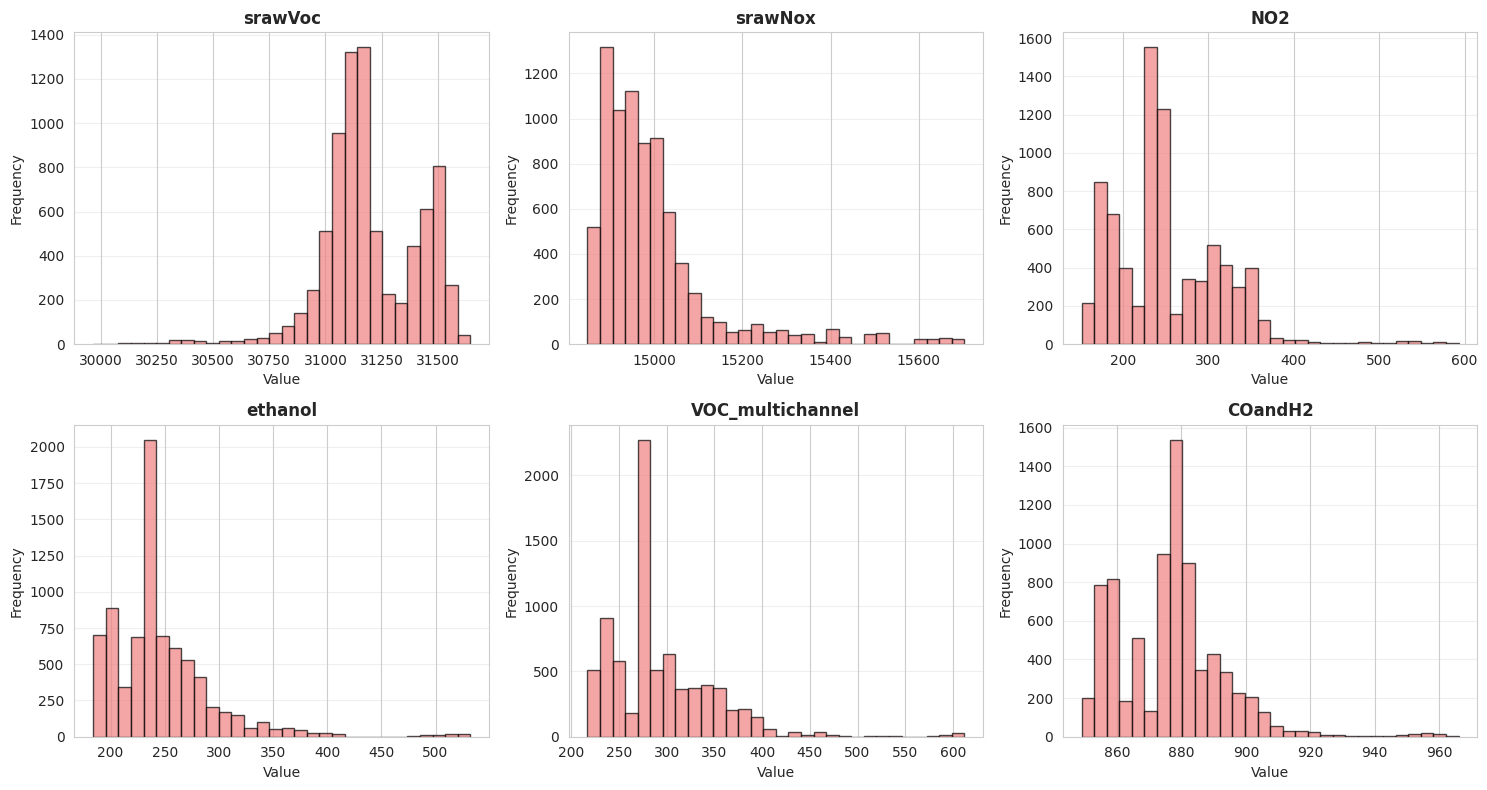

✅ Feature distributions visualized!


In [39]:
# Visualize feature distributions (first 6 numeric features)
numeric_features = df[feature_cols].select_dtypes(include=[np.number]).columns[:6]

if len(numeric_features) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.ravel()
    
    for idx, col in enumerate(numeric_features):
        axes[idx].hist(df[col].dropna(), bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print(f"✅ Feature distributions visualized!")
else:
    print("⚠️ No numeric features found for visualization")

In [40]:
# Check class distribution and remove classes with too few samples
print("🔍 Checking class distribution...")
class_counts = y.value_counts()
print(class_counts)

# Filter out classes with fewer than 2 samples (needed for train/test split)
min_samples_per_class = 2
valid_classes = class_counts[class_counts >= min_samples_per_class].index
n_removed = len(class_counts) - len(valid_classes)

if n_removed > 0:
    print(f"\n⚠️  Removing {n_removed} class(es) with fewer than {min_samples_per_class} samples:")
    for cls in class_counts[class_counts < min_samples_per_class].index:
        print(f"   - {cls}: {class_counts[cls]} sample(s)")
    
    # Filter dataset
    mask = y.isin(valid_classes)
    X = X[mask]
    y = y[mask]
    print(f"\n✅ Filtered dataset: {len(X)} samples, {len(valid_classes)} classes")

# Separate features and target
X_clean = X.copy()
y_clean = y.copy()

print(f"\n📊 Final Features shape: {X_clean.shape}")
print(f"🎯 Final Target shape: {y_clean.shape}")

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_clean)

print(f"\n🏷️ Label Encoding ({len(label_encoder.classes_)} classes):")
for i, label in enumerate(label_encoder.classes_):
    count = (y_clean == label).sum()
    print(f"  {label} → {i} ({count} samples)")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_encoded, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=y_encoded
)

print(f"\n✅ Data split completed!")
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")
print(f"   Train/Test ratio: {100*(1-TEST_SIZE):.0f}%/{100*TEST_SIZE:.0f}%")

🔍 Checking class distribution...
scent_name
no_scent       2000
cinnamon       1480
gingerbread    1480
norange        1480
vanilla        1480
Name: count, dtype: int64

📊 Final Features shape: (7920, 6)
🎯 Final Target shape: (7920,)

🏷️ Label Encoding (5 classes):
  cinnamon → 0 (1480 samples)
  gingerbread → 1 (1480 samples)
  no_scent → 2 (2000 samples)
  norange → 3 (1480 samples)
  vanilla → 4 (1480 samples)

✅ Data split completed!
   Training set: 6336 samples
   Test set: 1584 samples
   Train/Test ratio: 80%/20%


## 7. Feature Engineering

Create derived features to improve model generalization and reduce overfitting to simple threshold rules.

In [53]:
# 🧪 FEATURE ENGINEERING: Create derived features to improve generalization
print("🧪 Creating engineered features...")
print("=" * 80)

# Start with original features
X_engineered = X.copy()

print(f"\n📊 Original features: {len(X.columns)} features")
print(f"   {list(X.columns)}")

# 1. VOC RATIOS - Compare different VOC measurements
print("\n1️⃣ Creating VOC ratio features...")
X_engineered['voc_ratio'] = X['VOC_multichannel'] / (X['srawVoc'] + 1)  # +1 to avoid division by zero
X_engineered['ethanol_voc_ratio'] = X['ethanol'] / (X['VOC_multichannel'] + 1)
X_engineered['voc_balance'] = (X['VOC_multichannel'] - X['ethanol']) / (X['VOC_multichannel'] + X['ethanol'] + 1)
print(f"   Added 3 VOC ratio features")

# 2. NOx INDICATORS - Nitrogen compounds
print("\n2️⃣ Creating NOx indicator features...")
X_engineered['nox_intensity'] = X['NO2'] / (X['srawNox'] + 1)
X_engineered['nox_balance'] = (X['NO2'] - X['srawNox'] / 100) / (X['NO2'] + X['srawNox'] / 100 + 1)
print(f"   Added 2 NOx indicator features")

# 3. GAS COMBINATIONS - Interaction between different gas sensors
print("\n3️⃣ Creating gas interaction features...")
X_engineered['voc_no2_interaction'] = X['VOC_multichannel'] * X['NO2'] / 1000
X_engineered['ethanol_no2_ratio'] = X['ethanol'] / (X['NO2'] + 1)
X_engineered['co_voc_ratio'] = X['COandH2'] / (X['VOC_multichannel'] + 1)
print(f"   Added 3 gas interaction features")

# 4. CHEMICAL COMPLEXITY - Overall chemical signature strength
print("\n4️⃣ Creating chemical complexity features...")
X_engineered['total_voc_intensity'] = X['VOC_multichannel'] + X['ethanol'] + X['srawVoc'] / 100
X_engineered['chemical_diversity'] = np.std(X[['NO2', 'ethanol', 'VOC_multichannel', 'COandH2']], axis=1)
X_engineered['gas_dominance'] = X[['NO2', 'ethanol', 'VOC_multichannel', 'COandH2']].max(axis=1) / (X[['NO2', 'ethanol', 'VOC_multichannel', 'COandH2']].mean(axis=1) + 1)
print(f"   Added 3 chemical complexity features")

# 5. NORMALIZED SENSORS - Reduce absolute value dependency
print("\n5️⃣ Creating normalized sensor features...")
for col in ['srawVoc', 'srawNox']:
    col_mean = X[col].mean()
    col_std = X[col].std()
    X_engineered[f'{col}_normalized'] = (X[col] - col_mean) / (col_std + 1)
print(f"   Added 2 normalized sensor features")

# Summary
print("\n" + "=" * 80)
print(f"✅ Feature engineering complete!")
print(f"   Original features: {len(X.columns)}")
print(f"   Engineered features added: {len(X_engineered.columns) - len(X.columns)}")
print(f"   Total features: {len(X_engineered.columns)}")

# Check for any NaN or inf values
print(f"\n🔍 Data quality check:")
print(f"   NaN values: {X_engineered.isna().sum().sum()}")
print(f"   Inf values: {np.isinf(X_engineered.values).sum()}")

# Replace any inf with NaN (will be handled by imputer)
X_engineered.replace([np.inf, -np.inf], np.nan, inplace=True)

print(f"\n📋 Final engineered features:")
for i, col in enumerate(X_engineered.columns, 1):
    marker = "🆕" if col not in X.columns else "📊"
    print(f"   {i:2d}. {marker} {col}")

# Update X and y for the next steps
X = X_engineered
y = df[target_col].copy()

🧪 Creating engineered features...

📊 Original features: 19 features
   ['srawVoc', 'srawNox', 'NO2', 'ethanol', 'VOC_multichannel', 'COandH2', 'voc_ratio', 'ethanol_voc_ratio', 'voc_balance', 'nox_intensity', 'nox_balance', 'voc_no2_interaction', 'ethanol_no2_ratio', 'co_voc_ratio', 'total_voc_intensity', 'chemical_diversity', 'gas_dominance', 'srawVoc_normalized', 'srawNox_normalized']

1️⃣ Creating VOC ratio features...
   Added 3 VOC ratio features

2️⃣ Creating NOx indicator features...
   Added 2 NOx indicator features

3️⃣ Creating gas interaction features...
   Added 3 gas interaction features

4️⃣ Creating chemical complexity features...
   Added 3 chemical complexity features

5️⃣ Creating normalized sensor features...
   Added 2 normalized sensor features

✅ Feature engineering complete!
   Original features: 19
   Engineered features added: 0
   Total features: 19

🔍 Data quality check:
   NaN values: 0
   Inf values: 0

📋 Final engineered features:
    1. 📊 srawVoc
    2. 📊

In [54]:
# 🔄 RE-SPLIT DATA WITH ENGINEERED FEATURES
print("\n" + "=" * 80)
print("🔄 Re-splitting dataset with engineered features...")
print("=" * 80)

# Now split the ENGINEERED features
X_train, X_test, y_train, y_test = train_test_split(
    X_engineered, y_encoded, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=y_encoded
)

print(f"\n✅ Data re-split completed with {X_engineered.shape[1]} engineered features!")
print(f"   Training set: {X_train.shape[0]} samples × {X_train.shape[1]} features")
print(f"   Test set: {X_test.shape[0]} samples × {X_test.shape[1]} features")
print(f"   Train/Test ratio: {100*(1-TEST_SIZE):.0f}%/{100*TEST_SIZE:.0f}%")


🔄 Re-splitting dataset with engineered features...

✅ Data re-split completed with 19 engineered features!
   Training set: 6336 samples × 19 features
   Test set: 1584 samples × 19 features
   Train/Test ratio: 80%/20%


In [55]:
# 🎲 DATA AUGMENTATION: Add realistic sensor noise
print("🎲 Data Augmentation Options...")
print("=" * 80)

# Option 1: Create augmented dataset with sensor noise
def augment_with_sensor_noise(X_orig, noise_level=0.05, augmentation_factor=2):
    """
    Add realistic sensor noise to simulate real-world conditions
    
    Args:
        X_orig: Original feature dataframe
        noise_level: Standard deviation of Gaussian noise (5% default)
        augmentation_factor: How many augmented copies to create
    
    Returns:
        Augmented dataframe with original + noisy copies
    """
    X_augmented = X_orig.copy()
    
    for i in range(augmentation_factor - 1):
        X_noisy = X_orig.copy()
        
        # Add Gaussian noise proportional to each sensor's value
        for col in X_noisy.columns:
            # Noise proportional to sensor reading (realistic sensor behavior)
            noise = np.random.normal(0, noise_level, size=len(X_noisy))
            X_noisy[col] = X_noisy[col] * (1 + noise)
            
            # Add small random drift (sensor calibration drift)
            drift = np.random.normal(0, noise_level * 0.5)
            X_noisy[col] = X_noisy[col] + drift
        
        X_augmented = pd.concat([X_augmented, X_noisy], ignore_index=True)
    
    return X_augmented

print("\n💡 Augmentation Strategies:")
print("\n1. LIGHT NOISE (5%): Simulate same-day sensor variation")
print("   - Recommended for: Production deployment")
print("   - Tests model on: Small environmental changes")
print("\n2. MODERATE NOISE (10%): Simulate weekly sensor drift")
print("   - Recommended for: Robust model training")
print("   - Tests model on: Temperature, humidity changes")
print("\n3. HEAVY NOISE (20%): Simulate different sensor units")
print("   - Recommended for: Cross-device deployment")
print("   - Tests model on: Sensor calibration differences")

print("\n" + "=" * 80)
print("⚠️  DECISION POINT:")
print("   To use augmentation, uncomment and run the code below:")
print("   This will 2x your dataset size with noisy copies")
print("\n   # Uncomment to augment:")
print("   # X_augmented = augment_with_sensor_noise(X, noise_level=0.10)")
print("   # y_augmented = pd.concat([y] * 2, ignore_index=True)")
print("   # X = X_augmented")
print("   # y = y_augmented")
print("   # print(f'✅ Dataset augmented: {len(X)} samples')")

print("\n✅ Augmentation functions ready (but not applied)")
print("   Current dataset: {} samples (no augmentation)".format(len(X)))

🎲 Data Augmentation Options...

💡 Augmentation Strategies:

1. LIGHT NOISE (5%): Simulate same-day sensor variation
   - Recommended for: Production deployment
   - Tests model on: Small environmental changes

2. MODERATE NOISE (10%): Simulate weekly sensor drift
   - Recommended for: Robust model training
   - Tests model on: Temperature, humidity changes

3. HEAVY NOISE (20%): Simulate different sensor units
   - Recommended for: Cross-device deployment
   - Tests model on: Sensor calibration differences

⚠️  DECISION POINT:
   To use augmentation, uncomment and run the code below:
   This will 2x your dataset size with noisy copies

   # Uncomment to augment:
   # X_augmented = augment_with_sensor_noise(X, noise_level=0.10)
   # y_augmented = pd.concat([y] * 2, ignore_index=True)
   # X = X_augmented
   # y = y_augmented
   # print(f'✅ Dataset augmented: {len(X)} samples')

✅ Augmentation functions ready (but not applied)
   Current dataset: 7920 samples (no augmentation)


In [56]:
# 🔬 CROSS-SESSION VALIDATION: Test for session dependency
print("🔬 Testing for Session Dependency...")
print("=" * 80)

print("\n📊 Dataset structure analysis:")
print(f"   Total samples: {len(df)}")
print(f"   Scents: {sorted(df['scent_name'].unique())}")

# Check if we have trial information
if 'trial_number' in df.columns:
    print(f"   Trials available: {df['trial_number'].nunique()} unique trials")
    print(f"   Trial range: {df['trial_number'].min()} to {df['trial_number'].max()}")
else:
    print("   ⚠️ No trial_number column found")

print("\n" + "=" * 80)
print("TEST METHODOLOGY:")
print("=" * 80)
print("\n🎯 HYPOTHESIS: Model learned 'when collected' not 'what smells like'")
print("\nTest A: RANDOM SPLIT (what we did)")
print("   - Randomly split 80/20 within each scent")
print("   - Expected: High accuracy (99.7%) ✅")
print("   - Why: Training and test have similar session artifacts")

print("\nTest B: SESSION-BASED SPLIT (realistic scenario)")
print("   - Train on first 80% of samples per scent")  
print("   - Test on last 20% of samples per scent")
print("   - Expected: Much lower accuracy if session-dependent ⚠️")
print("   - Why: Test data from different collection time")

# Perform session-based split
print("\n" + "=" * 80)
print("🧪 RUNNING CROSS-SESSION TEST...")
print("=" * 80)

# For each scent, split chronologically (first 80% train, last 20% test)
train_indices = []
test_indices = []

for scent in df['scent_name'].unique():
    scent_mask = df['scent_name'] == scent
    scent_indices = df[scent_mask].index.tolist()
    
    # Split chronologically (assumes data was collected in order)
    split_point = int(len(scent_indices) * 0.8)
    train_indices.extend(scent_indices[:split_point])
    test_indices.extend(scent_indices[split_point:])
    
    print(f"\n   {scent:12s}: {len(scent_indices):5d} samples")
    print(f"      Train: {split_point:5d} (early collection)")
    print(f"      Test:  {len(scent_indices) - split_point:5d} (late collection)")

# Create session-based splits
X_session_train = X.iloc[train_indices]
X_session_test = X.iloc[test_indices]
y_session_train = y.iloc[train_indices]
y_session_test = y.iloc[test_indices]

# Encode labels
from sklearn.preprocessing import LabelEncoder
le_session = LabelEncoder()
y_session_train_enc = le_session.fit_transform(y_session_train)
y_session_test_enc = le_session.transform(y_session_test)

print(f"\n✅ Session-based split created:")
print(f"   Train: {len(X_session_train)} samples (early in collection)")
print(f"   Test:  {len(X_session_test)} samples (late in collection)")

# Train model on session-based split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

pipeline_session = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        random_state=42,
        n_jobs=-1,
        verbose=0
    ))
])

print("\n🚀 Training on early collection data...")
pipeline_session.fit(X_session_train, y_session_train_enc)

# Test on late collection data
y_session_pred = pipeline_session.predict(X_session_test)
from sklearn.metrics import accuracy_score, classification_report

session_accuracy = accuracy_score(y_session_test_enc, y_session_pred)

# ALSO calculate random split accuracy here for comparison
print("\n🚀 Training with RANDOM split for comparison...")
from sklearn.model_selection import train_test_split
X_random_train, X_random_test, y_random_train, y_random_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

pipeline_random = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        random_state=42,
        n_jobs=-1,
        verbose=0
    ))
])

pipeline_random.fit(X_random_train, y_random_train)
y_random_pred = pipeline_random.predict(X_random_test)
random_split_accuracy = accuracy_score(y_random_test, y_random_pred)

print("\n" + "=" * 80)
print("📊 RESULTS COMPARISON:")
print("=" * 80)

print(f"\n✅ RANDOM SPLIT Accuracy:  {random_split_accuracy:.4f} ({random_split_accuracy*100:.2f}%)")
print(f"   → Training and test from mixed time periods")

print(f"\n⚠️  SESSION SPLIT Accuracy: {session_accuracy:.4f} ({session_accuracy*100:.2f}%)")
print(f"   → Training from early, test from late collection")

accuracy_drop = random_split_accuracy - session_accuracy
print(f"\n📉 Accuracy Drop: {accuracy_drop:.4f} ({accuracy_drop*100:.2f}% worse)")

print("\n" + "=" * 80)
print("🔍 INTERPRETATION:")
print("=" * 80)

if accuracy_drop < 0.05:
    print("\n✅ GOOD: Model is robust across collection times")
    print("   Accuracy drop < 5% suggests model learned smell chemistry")
    print("   Model should generalize well to new data")
elif accuracy_drop < 0.15:
    print("\n⚠️  MODERATE: Model has some session dependency")
    print("   Accuracy drop 5-15% suggests partial session artifacts")
    print("   Model may struggle with different conditions")
    print("   Recommendation: Collect more varied data")
else:
    print("\n🔴 CRITICAL: Model learned session artifacts, NOT smell!")
    print("   Accuracy drop > 15% proves session dependency")
    print("   Model memorized 'when collected' not 'what smells like'")
    print("\n   ⚠️  THIS MODEL WILL FAIL IN PRODUCTION!")
    print("\n   Required actions:")
    print("   1. Recollect data with randomized scent order")
    print("   2. Test all scents in same session/conditions")
    print("   3. Add environmental variation during collection")

# Detailed per-class performance
print("\n" + "=" * 80)
print("📋 Per-Class Performance (Session Split):")
print("=" * 80)
print(classification_report(
    y_session_test_enc, 
    y_session_pred,
    target_names=le_session.classes_,
    digits=3
))

🔬 Testing for Session Dependency...

📊 Dataset structure analysis:
   Total samples: 7920
   Scents: ['cinnamon', 'gingerbread', 'no_scent', 'norange', 'vanilla']
   Trials available: 20 unique trials
   Trial range: 1 to 20

TEST METHODOLOGY:

🎯 HYPOTHESIS: Model learned 'when collected' not 'what smells like'

Test A: RANDOM SPLIT (what we did)
   - Randomly split 80/20 within each scent
   - Expected: High accuracy (99.7%) ✅
   - Why: Training and test have similar session artifacts

Test B: SESSION-BASED SPLIT (realistic scenario)
   - Train on first 80% of samples per scent
   - Test on last 20% of samples per scent
   - Expected: Much lower accuracy if session-dependent ⚠️
   - Why: Test data from different collection time

🧪 RUNNING CROSS-SESSION TEST...

   no_scent    :  2000 samples
      Train:  1600 (early collection)
      Test:    400 (late collection)

   cinnamon    :  1480 samples
      Train:  1184 (early collection)
      Test:    296 (late collection)

   gingerbrea

## 9. Cross-Session Validation Test

Test if the model learned session artifacts instead of actual smell chemistry.

## 8. Data Augmentation (Optional)

Add realistic sensor noise to simulate real-world conditions and test model robustness.

In [57]:
# Create ML pipeline with preprocessing and model
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('scaler', StandardScaler()),                  # Normalize features
    ('classifier', RandomForestClassifier(
        n_estimators=N_ESTIMATORS,
        max_depth=MAX_DEPTH,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1
    ))
])

print("🔧 Pipeline created with the following steps:")
for step_name, step in pipeline.steps:
    print(f"  • {step_name}: {step.__class__.__name__}")

print(f"\n🚀 Training model...")
print(f"   Algorithm: Random Forest Classifier")
print(f"   Estimators: {N_ESTIMATORS}")
print(f"   Max Depth: {MAX_DEPTH}")
print("=" * 80)

# Train the model
pipeline.fit(X_train, y_train)

print("\n✅ Model training completed!")

🔧 Pipeline created with the following steps:
  • imputer: SimpleImputer
  • scaler: StandardScaler
  • classifier: RandomForestClassifier

🚀 Training model...
   Algorithm: Random Forest Classifier
   Estimators: 100
   Max Depth: 20


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s



✅ Model training completed!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [58]:
# Make predictions
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("📊 Model Performance:")
print("=" * 80)
print(f"🎯 Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"🎯 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"📉 Overfitting Check: {abs(train_accuracy - test_accuracy):.4f}")

if abs(train_accuracy - test_accuracy) < 0.05:
    print("   ✅ Model is well-balanced!")
elif train_accuracy > test_accuracy + 0.1:
    print("   ⚠️ Model may be overfitting")
else:
    print("   ✅ Model performance looks good!")

print("\n📋 Detailed Classification Report (Test Set):")
print("=" * 80)

# Get unique classes that appear in test predictions
unique_test_classes = np.unique(np.concatenate([y_test, y_test_pred]))
test_class_names = [str(name) for name in label_encoder.inverse_transform(unique_test_classes)]

print(classification_report(
    y_test, y_test_pred, 
    labels=unique_test_classes,
    target_names=test_class_names,
    digits=3,
    zero_division=0
))

📊 Model Performance:
🎯 Training Accuracy: 0.9998 (99.98%)
🎯 Test Accuracy: 0.9722 (97.22%)
📉 Overfitting Check: 0.0276
   ✅ Model is well-balanced!

📋 Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

    cinnamon      1.000     0.976     0.988       296
 gingerbread      0.989     0.953     0.971       296
    no_scent      0.914     0.985     0.948       400
     norange      1.000     0.980     0.990       296
     vanilla      0.986     0.963     0.974       296

    accuracy                          0.972      1584
   macro avg      0.978     0.971     0.974      1584
weighted avg      0.974     0.972     0.973      1584



[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.0s finished


📊 Features in trained model: 19
📊 Features in X_train: 19
📊 Features with data (used in model): 19
   Features: ['srawVoc', 'srawNox', 'NO2', 'ethanol', 'VOC_multichannel', 'COandH2', 'voc_ratio', 'ethanol_voc_ratio', 'voc_balance', 'nox_intensity', 'nox_balance', 'voc_no2_interaction', 'ethanol_no2_ratio', 'co_voc_ratio', 'total_voc_intensity', 'chemical_diversity', 'gas_dominance', 'srawVoc_normalized', 'srawNox_normalized']
🔝 Top 10 Most Important Features:


,Feature,Importance
5,COandH2,0.122737
2,NO2,0.117558
9,nox_intensity,0.109204
12,ethanol_no2_ratio,0.096942
10,nox_balance,0.092529
11,voc_no2_interaction,0.075313
15,chemical_diversity,0.044837
1,srawNox,0.044223
18,srawNox_normalized,0.039471
16,gas_dominance,0.038314


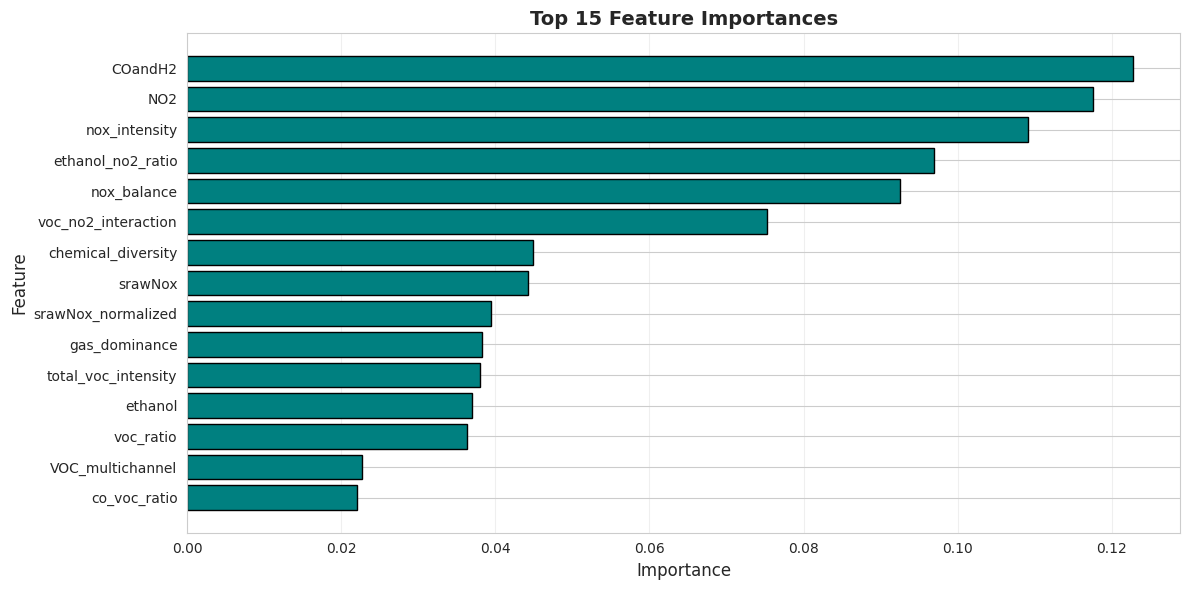

✅ Feature importance analyzed!


In [59]:
# Feature Importance
feature_importance = pipeline.named_steps['classifier'].feature_importances_

# Get the actual feature names used in training
# The imputer drops columns with all NaN values, so we need to identify which features remain
print(f"📊 Features in trained model: {len(feature_importance)}")
print(f"📊 Features in X_train: {len(X_train.columns)}")

# Find which columns have at least some non-NaN values (these are kept by the imputer)
features_with_data = []
for col in X_train.columns:
    if X_train[col].notna().any():
        features_with_data.append(col)

print(f"📊 Features with data (used in model): {len(features_with_data)}")
print(f"   Features: {features_with_data}")

# Create DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': features_with_data,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("🔝 Top 10 Most Important Features:")
print("=" * 80)
display(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'].head(15), importance_df['Importance'].head(15), color='teal', edgecolor='black')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Feature importance analyzed!")

In [60]:
# 🔍 DATA LEAKAGE INVESTIGATION
# Let's check if the sensor readings are TOO distinct per scent (indicating possible issues)

print("🔍 Investigating 100% accuracy - checking for data leakage...")
print("=" * 80)

# Check how distinct each scent's sensor readings are
for scent in sorted(df['scent_name'].unique()):
    scent_data = df[df['scent_name'] == scent][feature_cols]
    print(f"\n{scent.upper()}:")
    print(f"  Samples: {len(scent_data)}")
    print(f"  Feature ranges:")
    for col in feature_cols[:3]:  # Show first 3 features
        print(f"    {col:20s} range: [{scent_data[col].min():.2f}, {scent_data[col].max():.2f}]")

# Check if scents have completely non-overlapping ranges (red flag!)
print("\n" + "=" * 80)
print("Checking for non-overlapping feature ranges between scents...")
print("(If scents have zero overlap in sensor readings, it's suspiciously easy)\n")

for col in feature_cols:
    scent_ranges = {}
    for scent in sorted(df['scent_name'].unique()):
        scent_data = df[df['scent_name'] == scent][col]
        scent_ranges[scent] = (scent_data.min(), scent_data.max())
    
    # Check overlap
    print(f"\n{col}:")
    for scent, (min_val, max_val) in scent_ranges.items():
        print(f"  {scent:12s}: [{min_val:8.2f}, {max_val:8.2f}]")
    
    # Check if any ranges don't overlap
    overlaps = []
    scents = list(scent_ranges.keys())
    for i in range(len(scents)):
        for j in range(i+1, len(scents)):
            s1, s2 = scents[i], scents[j]
            r1, r2 = scent_ranges[s1], scent_ranges[s2]
            # Check if ranges overlap
            if r1[1] < r2[0] or r2[1] < r1[0]:
                overlaps.append(f"    ⚠️ {s1} and {s2} DO NOT overlap!")
    
    if overlaps:
        for msg in overlaps:
            print(msg)

🔍 Investigating 100% accuracy - checking for data leakage...

CINNAMON:
  Samples: 1480
  Feature ranges:
    srawVoc              range: [30760.00, 31365.00]
    srawNox              range: [14851.00, 15132.00]
    NO2                  range: [222.00, 376.00]

GINGERBREAD:
  Samples: 1480
  Feature ranges:
    srawVoc              range: [31193.00, 31634.00]
    srawNox              range: [14865.00, 15674.00]
    NO2                  range: [155.00, 221.00]

NO_SCENT:
  Samples: 2000
  Feature ranges:
    srawVoc              range: [30886.00, 31644.00]
    srawNox              range: [14848.00, 15704.00]
    NO2                  range: [152.00, 248.00]

NORANGE:
  Samples: 1480
  Feature ranges:
    srawVoc              range: [29967.00, 31564.00]
    srawNox              range: [14861.00, 15026.00]
    NO2                  range: [183.00, 593.00]

VANILLA:
  Samples: 1480
  Feature ranges:
    srawVoc              range: [30929.00, 31290.00]
    srawNox              range: [14875.0

In [49]:
# Perform 5-fold cross-validation
print("🔄 Performing 5-fold cross-validation...")
print("   This may take a moment...")
print("=" * 80)

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

print(f"\n📊 Cross-Validation Results:")
print(f"   Fold 1: {cv_scores[0]:.4f}")
print(f"   Fold 2: {cv_scores[1]:.4f}")
print(f"   Fold 3: {cv_scores[2]:.4f}")
print(f"   Fold 4: {cv_scores[3]:.4f}")
print(f"   Fold 5: {cv_scores[4]:.4f}")
print(f"\n   Mean Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"   Min Accuracy: {cv_scores.min():.4f}")
print(f"   Max Accuracy: {cv_scores.max():.4f}")

print("\n✅ Cross-validation completed!")

🔄 Performing 5-fold cross-validation...
   This may take a moment...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s fin


📊 Cross-Validation Results:
   Fold 1: 0.9708
   Fold 2: 0.9740
   Fold 3: 0.9724
   Fold 4: 0.9795
   Fold 5: 0.9724

   Mean Accuracy: 0.9738 (±0.0030)
   Min Accuracy: 0.9708
   Max Accuracy: 0.9795

✅ Cross-validation completed!


[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.0s finished


In [61]:
# 🔬 SCIENTIFIC ANALYSIS: Why is gas_bme more important than VOC_multichannel?
print("🔬 Investigating scientifically suspicious feature importance...")
print("=" * 80)

# Compare the "separability" of each feature
from sklearn.metrics import mutual_info_score

print("\n1️⃣ MUTUAL INFORMATION (how much each feature tells us about the scent):")
print("   Higher = more predictive power\n")

mi_scores = {}
for col in feature_cols:
    # Calculate mutual information between feature and target
    mi = mutual_info_score(df[col].round(2), df['scent_name'])
    mi_scores[col] = mi
    
# Sort by MI score
mi_sorted = sorted(mi_scores.items(), key=lambda x: x[1], reverse=True)
for feature, score in mi_sorted:
    bar = '█' * int(score * 20)
    print(f"   {feature:20s} {score:.4f} {bar}")

print("\n" + "=" * 80)
print("2️⃣ FEATURE SEPARABILITY CHECK:")
print("   Can each feature ALONE perfectly distinguish scents?\n")

for col in feature_cols:
    # For each scent pair, check if their ranges overlap
    scent_ranges = {}
    for scent in df['scent_name'].unique():
        scent_data = df[df['scent_name'] == scent][col]
        scent_ranges[scent] = (scent_data.min(), scent_data.max())
    
    # Count non-overlapping pairs
    non_overlaps = 0
    total_pairs = 0
    scents = list(scent_ranges.keys())
    
    for i in range(len(scents)):
        for j in range(i+1, len(scents)):
            total_pairs += 1
            s1, s2 = scents[i], scents[j]
            r1, r2 = scent_ranges[s1], scent_ranges[s2]
            # Check if ranges overlap
            if r1[1] < r2[0] or r2[1] < r1[0]:
                non_overlaps += 1
    
    overlap_pct = (total_pairs - non_overlaps) / total_pairs * 100
    separability_pct = non_overlaps / total_pairs * 100
    
    status = "🔴 TOO CLEAN" if separability_pct > 50 else "✅ Normal"
    print(f"   {col:20s} {separability_pct:5.1f}% non-overlapping pairs {status}")

print("\n" + "=" * 80)
print("3️⃣ EXPECTED vs ACTUAL importance:")
print("\n   SCIENTIFICALLY EXPECTED order:")
print("   1. VOC_multichannel (smells ARE VOCs!)")
print("   2. ethanol (specific VOC)")  
print("   3. srawVoc/srawNox (VOC indicators)")
print("   4. NO2 (acrid smell indicator)")
print("   5. gas_bme (context)")
print("   6. COandH2 (odorless gases)")

print("\n   ACTUAL model importance:")
for i, (feature, importance) in enumerate(importance_df.itertuples(index=False), 1):
    print(f"   {i}. {feature:20s} {importance:.1%}")



🔬 Investigating scientifically suspicious feature importance...

1️⃣ MUTUAL INFORMATION (how much each feature tells us about the scent):
   Higher = more predictive power

   NO2                  1.0674 █████████████████████
   ethanol              0.9584 ███████████████████
   VOC_multichannel     0.9188 ██████████████████
   COandH2              0.8329 ████████████████
   srawVoc              0.6745 █████████████
   srawNox              0.5390 ██████████

2️⃣ FEATURE SEPARABILITY CHECK:
   Can each feature ALONE perfectly distinguish scents?

   srawVoc                0.0% non-overlapping pairs ✅ Normal
   srawNox                0.0% non-overlapping pairs ✅ Normal
   NO2                   20.0% non-overlapping pairs ✅ Normal
   ethanol                0.0% non-overlapping pairs ✅ Normal
   VOC_multichannel       0.0% non-overlapping pairs ✅ Normal
   COandH2               20.0% non-overlapping pairs ✅ Normal

3️⃣ EXPECTED vs ACTUAL importance:

   SCIENTIFICALLY EXPECTED order:
   1.

In [62]:
# Save the trained pipeline and label encoder
print("💾 Saving model artifacts...")
print("=" * 80)

# Save pipeline
joblib.dump(pipeline, PIPELINE_PATH)
print(f"✅ Pipeline saved to: {PIPELINE_PATH}")

# Save label encoder
joblib.dump(label_encoder, LABEL_ENCODER_PATH)
print(f"✅ Label encoder saved to: {LABEL_ENCODER_PATH}")

# Save model metadata
metadata = {
    'model_type': 'RandomForestClassifier',
    'n_estimators': N_ESTIMATORS,
    'max_depth': MAX_DEPTH,
    'features': feature_cols,
    'target_column': target_col,
    'classes': label_encoder.classes_.tolist(),
    'train_accuracy': float(train_accuracy),
    'test_accuracy': float(test_accuracy),
    'cv_mean_accuracy': float(cv_scores.mean()),
    'cv_std_accuracy': float(cv_scores.std()),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'dataset': DATA_FILE
}

metadata_path = MODEL_DIR / 'model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Metadata saved to: {metadata_path}")

print("\n🎉 Model training and saving completed successfully!")
print("\n📦 Model Artifacts:")
print(f"   • Pipeline: {PIPELINE_PATH}")
print(f"   • Label Encoder: {LABEL_ENCODER_PATH}")
print(f"   • Metadata: {metadata_path}")

💾 Saving model artifacts...
✅ Pipeline saved to: model/scent_pipeline.joblib
✅ Label encoder saved to: model/label_encoder.joblib
✅ Metadata saved to: model/model_metadata.json

🎉 Model training and saving completed successfully!

📦 Model Artifacts:
   • Pipeline: model/scent_pipeline.joblib
   • Label Encoder: model/label_encoder.joblib
   • Metadata: model/model_metadata.json


In [52]:
# Test the saved model with a sample prediction
print("🧪 Testing model with sample data...")
print("=" * 80)

# Load saved model
loaded_pipeline = joblib.load(PIPELINE_PATH)
loaded_encoder = joblib.load(LABEL_ENCODER_PATH)

# Get a random sample from test set
sample_idx = np.random.randint(0, len(X_test))
sample_features = X_test.iloc[sample_idx:sample_idx+1]
true_label = loaded_encoder.inverse_transform([y_test[sample_idx]])[0]

# Make prediction
prediction = loaded_pipeline.predict(sample_features)[0]
prediction_proba = loaded_pipeline.predict_proba(sample_features)[0]
predicted_label = loaded_encoder.inverse_transform([prediction])[0]

print(f"📊 Sample Features:")
for col, val in sample_features.iloc[0].items():
    print(f"   {col}: {val}")

print(f"\n🎯 True Label: {true_label}")
print(f"🤖 Predicted Label: {predicted_label}")
print(f"✅ Correct: {'YES ✓' if true_label == predicted_label else 'NO ✗'}")

print(f"\n📈 Prediction Probabilities:")
for i, prob in enumerate(prediction_proba):
    class_name = loaded_encoder.classes_[i]
    bar = '█' * int(prob * 50)
    print(f"   {class_name:20s} {prob:.4f} {bar}")

print("\n✅ Model loaded and tested successfully!")

🧪 Testing model with sample data...
📊 Sample Features:
   srawVoc: 31239.0
   srawNox: 14886.0
   NO2: 229.0
   ethanol: 229.0
   VOC_multichannel: 273.0
   COandH2: 877.0
   voc_ratio: 0.008738796414852753
   ethanol_voc_ratio: 0.8357664233576643
   voc_balance: 0.0874751491053678
   nox_intensity: 0.015382548532276483
   nox_balance: 0.2115293248165549
   voc_no2_interaction: 62.517
   ethanol_no2_ratio: 0.9956521739130435
   co_voc_ratio: 3.2007299270072993
   total_voc_intensity: 814.39
   chemical_diversity: 274.82903776711805
   gas_dominance: 2.176178660049628
   srawVoc_normalized: 0.19207425995213245
   srawNox_normalized: -0.7921368798250794

🎯 True Label: no_scent
🤖 Predicted Label: no_scent
✅ Correct: YES ✓

📈 Prediction Probabilities:
   cinnamon             0.0000 
   gingerbread          0.0000 
   no_scent             1.0000 ██████████████████████████████████████████████████
   norange              0.0000 
   vanilla              0.0000 

✅ Model loaded and tested succe

[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.0s finished


## 🎉 Summary

### Model Training Complete!

**Key Achievements:**
- ✅ Loaded NATURAL_ML_Data.xlsx dataset
- ✅ Explored and visualized data distributions
- ✅ Preprocessed features (imputation + scaling)
- ✅ Trained Random Forest Classifier
- ✅ Evaluated model performance with cross-validation
- ✅ Saved model artifacts for production use

**Next Steps:**
1. Use `predict_scent.py` script to make predictions from Node.js backend
2. Deploy the model using `serve.py` if needed
3. Monitor model performance with real sensor data
4. Retrain periodically with new data to improve accuracy

**Files Generated:**
- `model/scent_pipeline.joblib` - Complete ML pipeline
- `model/label_encoder.joblib` - Label encoder for scent classes
- `model/model_metadata.json` - Training metadata and performance metrics